In [37]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
import os

# Font similar to LaTeX:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

In [228]:
cases = {#"case 1" : "./new_depletion_results/barc-v5-full-tank-10-percent-flibe",
         "case 2" : "./depletion_results_final/barc-v7-10-percent-waste-full-tank",
         "case 3" : "./depletion_results_final/barc-v7-10-percent-waste-full-tank-fertile-removed",
         "case 4" : "./depletion_results_final/barc-v7-10-percent-waste-sludge-CsSr-removed",
         "case 5" : "./depletion_results_final/barc-v7-10-percent-waste-sludge-CsSr-fertile-removed",
         "case 6" : "./depletion_results_final/barc-v7-10-percent-waste-sludge",
         "case 7" : "./depletion_results_final/barc-v7-10-percent-waste-sludge-fertile-removed",
         "case 8" : "./depletion_results_final/barc-v7-10-percent-waste-sludge-NO-RADIONUCLIDES",
         "case 9" : "./depletion_results_final/barc-v7-10-percent-waste-sludge-U238-removed",
         }

results = {}
for case, filename in cases.items():
    print(f"Processing {case}")
    results[case] = openmc.deplete.Results(filename+'/depletion_results.h5')

Processing case 2
Processing case 3
Processing case 4
Processing case 5
Processing case 6
Processing case 7
Processing case 8
Processing case 9


In [188]:
# activities of all problem nuclides over time

problem_nuclides = ["Ni59","Nb94","I129","H3","Co60"]
actinides = ["U238","U235","Pu239","Pu240","Pu241","Cm242","Am241"]
fission_products = ['Y90',"Sr90","Cs137","Tc99"]

activities = {}
masses = {}

for case in cases.keys():
    try:
        times, activity = results[case].get_activity(mat="8",by_nuclide=True)
        activities[case] = activity
    except:
        times, activity = results[case].get_activity(mat="9",by_nuclide=True)
        activities[case] = activity

30073880485.67532


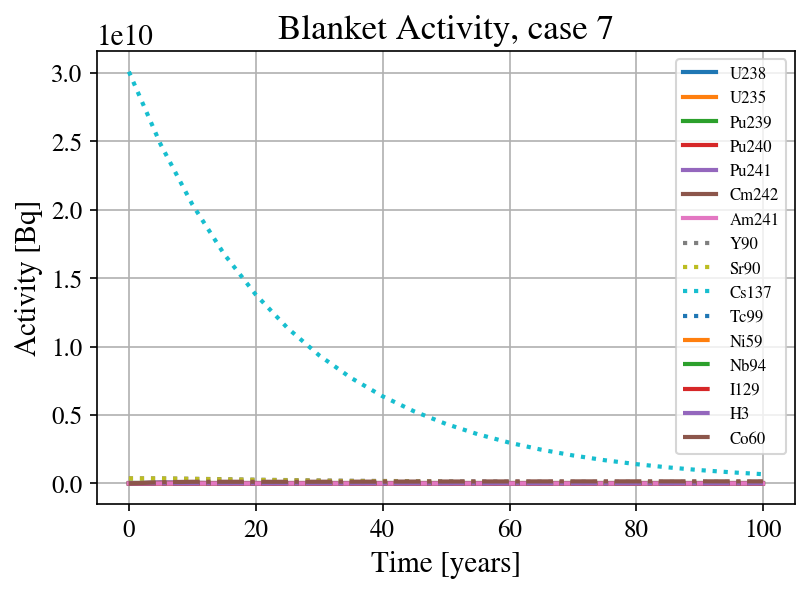

In [216]:
fig, ax = plt.subplots(dpi=150)

case = "case 7"

total_activity = np.zeros(len(results[case].get_times()))

for i in actinides:
    try:
        times = results[case].get_times(time_units="a")
        values = [ia[i] for ia in activities[case]]
        total_activity += values
        ax.plot(times, values, label=i,ls="-",lw=2)
    except:
        continue

for i in fission_products:
    try:
        times = results[case].get_times(time_units="a")
        values = [ia[i] for ia in activities[case]]
        total_activity += values
        ax.plot(times, values, label=i,ls=":",lw=2)
    except:
        continue

for i in problem_nuclides:
    try:
        times = results[case].get_times(time_units="a")
        values = [ia[i] for ia in activities[case]]
        total_activity += values
        ax.plot(times, values, label=i,ls="-.",lw=2)
    except: 
        continue

print(activities[case][0]["Cs137"])
#ax.plot(times, total_activity, label="Total", color="black",lw=2)
#ax.plot(times, activities[case][0]["Cs137"]*np.exp(-times/43.4), label="Cs137 decay", color="red",lw=2)
ax.legend(fontsize=8,loc="upper right")
#ax.set_ylim(1e0,3e8)
plt.xlabel("Time [years]")
plt.ylabel("Activity [Bq]")
plt.title(f"Blanket Activity, {case}")
plt.savefig("old.png")
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)


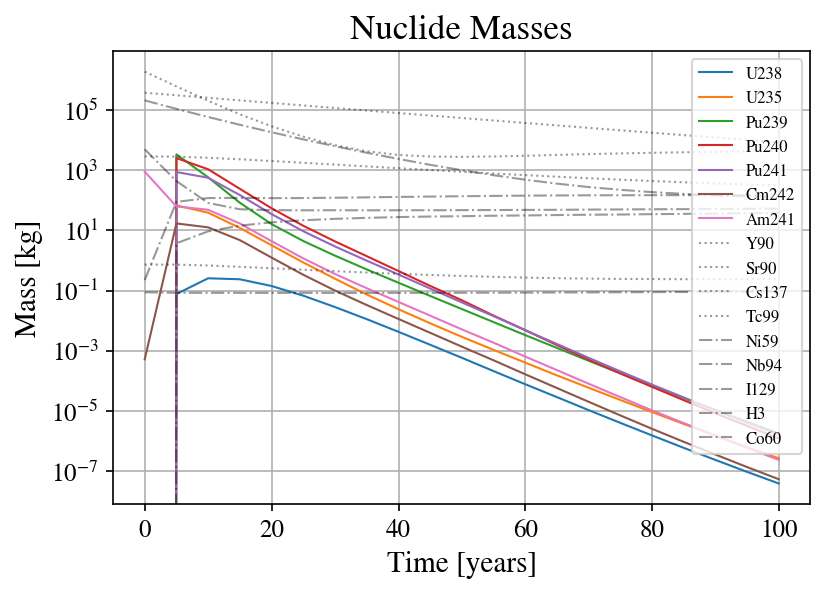

In [218]:
fig, ax = plt.subplots(dpi=150)

case = "case 7"
mat_id = "8"
total_mass = np.zeros(len(results[case].get_times()))

for i in actinides:
    try:
        times, values = results[case].get_mass(mat=mat_id,nuc=i,mass_units="g",time_units="a")
        total_mass += values
        ax.plot(times, values, label=i,ls="-",lw=1)
    except:
        print(f"Could not find {i}")
        continue

for i in fission_products:
    try:
        times, values = results[case].get_mass(mat=mat_id,nuc=i,mass_units="g",time_units="a")
        total_mass += values
        ax.plot(times, values, label=i,ls=":",lw=1,color="k",alpha=0.4)
    except:
        continue

for i in problem_nuclides:
    try:
        times, values = results[case].get_mass(mat=mat_id,nuc=i,mass_units="g",time_units="a")
        total_mass += values
        ax.semilogy(times, values, label=i,ls="-.",lw=1, color="k",alpha=0.4)
    except:
        continue

#ax.semilogy(times, total_mass, label="Total", color="black",lw=2)
ax.legend(fontsize=8,loc="upper right")
#ax.set_yscale("log")
#ax.set_ylim(1,1e6)
ax.grid()
plt.xlabel("Time [years]")
plt.ylabel("Mass [kg]")
# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.title("Nuclide Masses")
plt.savefig("old.png")

case 2 -0.009455219386542627
case 3 -0.012610190134837098
case 4 -35.81310984494645
case 5 -147.4992768812156
case 6 -188.71724596172672
case 7 -313.9972993234427
case 8 -314.02230399154706
case 9 -314.02230399154706


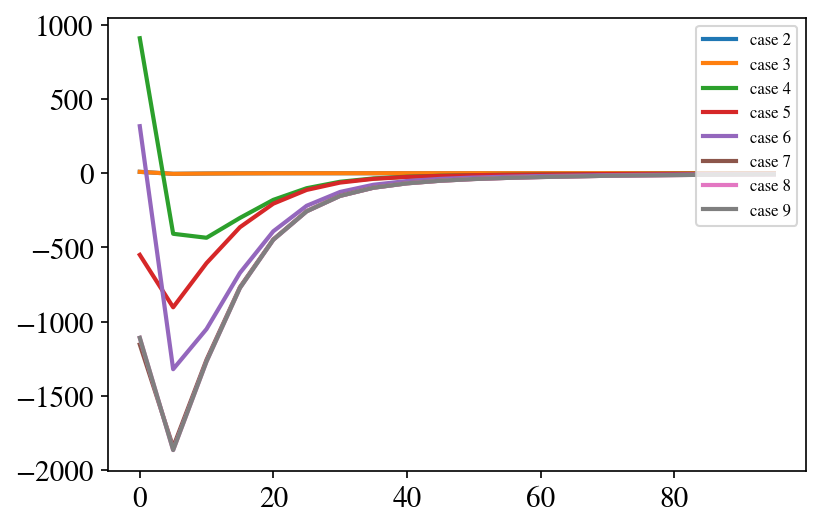

In [215]:
# get the burnup amount in kg / FPY over time (and average)
nuclides_full = ['Am241','Am242_m1','Am243','Cm242','Cm243','Cm244',
                 'Cm245','Cm246','Cm247','I129','Np236','Np237',
                 'Pu238','Pu239','Pu240','Pu241','Pu242','Pu244',
                 'Tc99',"Sr90","Cs137","Co60","U235","Ni59","Nb94"]

total_mass = np.zeros(21)
mat_id = "8"
fig, ax = plt.subplots(dpi=150)
for icase in cases.keys():
    for i in nuclides_full:
        try:
            times, values = results[icase].get_mass(mat=mat_id,nuc=i,mass_units="kg",time_units="a")
            total_mass += values
            #ax.semilogy(times, values, label=i,ls="-.",lw=1)
        except KeyError:
            continue

    diff = np.diff(total_mass)
    print(icase, diff.mean())
    ax.plot(times[:-1], diff, label=icase, lw=2)
    ax.legend(fontsize=8,loc="upper right")

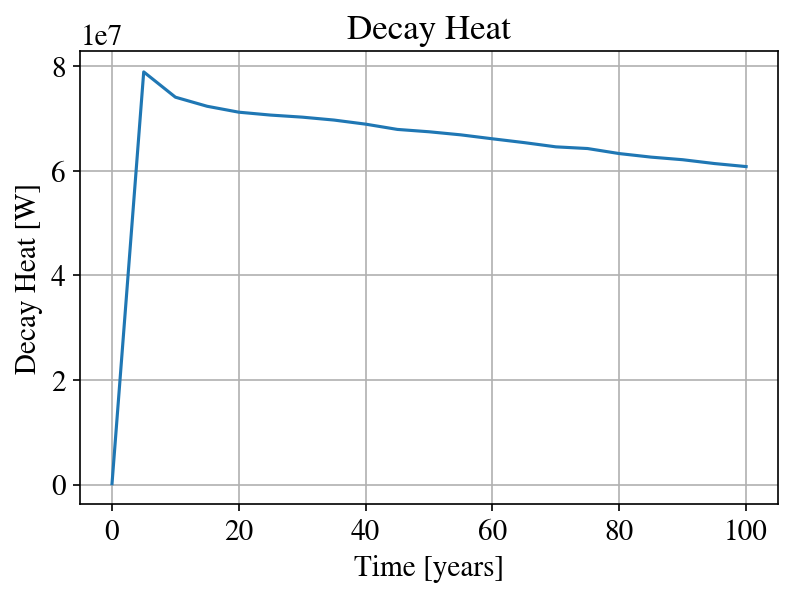

In [222]:
fig, ax = plt.subplots(dpi=150)

case = "case 7"
mat_id = "8"
total_mass = np.zeros(len(results[case].get_times()))

times, heat = results[case].get_decay_heat(mat=mat_id)
ax.plot(times/60/60/24/365, heat)
ax.set_ylabel("Decay Heat [W]")
ax.set_xlabel("Time [years]")
plt.title("Decay Heat")
ax.grid()


In [225]:
# Export material 
from barc_blanket.materials.waste_classification import sum_of_fractions
depleted_material = results[case].export_to_materials(burnup_index=20, path=filename+"/materials.xml")
depleted_material
sum_of_fractions(depleted_material[5],1,1)


(322.178973684534,
 {'C14': 0.4486961992411388,
  'Tc99': 91.4250162704787,
  'I129': 3.9288466656997554,
  'Np237': 1.052631825129973,
  'Pu238': 4.763514974763239,
  'Pu239': 80.06247178699859,
  'Pu240': 16.430837467904933,
  'Pu241': 1.7067423609834964,
  'Pu242': 0.024611935204663333,
  'Am241': 122.14907279699382,
  'Am243': 0.07076285025137562,
  'Cm242': 0.00034414325896560714,
  'Cm243': 0.005205521667044431,
  'Cm244': 0.11021888595832566})

/home/hallj/.local/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=8.
  warn(msg, IDWarning)


Time: 0 years
Table 1 sum of fractions: 3386.01
Table 2 sum of fractions: 945.18
Time: 5 years
Table 1 sum of fractions: 69441.75
Table 2 sum of fractions: 755.82
Time: 10 years
Table 1 sum of fractions: 17428.23
Table 2 sum of fractions: 604.78
Time: 15 years
Table 1 sum of fractions: 9802.85
Table 2 sum of fractions: 484.37
Time: 20 years
Table 1 sum of fractions: 4964.92
Table 2 sum of fractions: 388.69
Time: 25 years
Table 1 sum of fractions: 2056.04
Table 2 sum of fractions: 312.47
Time: 30 years
Table 1 sum of fractions: 759.15
Table 2 sum of fractions: 251.66
Time: 35 years
Table 1 sum of fractions: 266.96
Table 2 sum of fractions: 203.12
Time: 40 years
Table 1 sum of fractions: 91.40
Table 2 sum of fractions: 164.28
Time: 45 years
Table 1 sum of fractions: 31.29
Table 2 sum of fractions: 133.16
Time: 50 years
Table 1 sum of fractions: 11.71
Table 2 sum of fractions: 108.14
Time: 55 years
Table 1 sum of fractions: 5.10
Table 2 sum of fractions: 88.00
Time: 60 years
Table 1 sum o

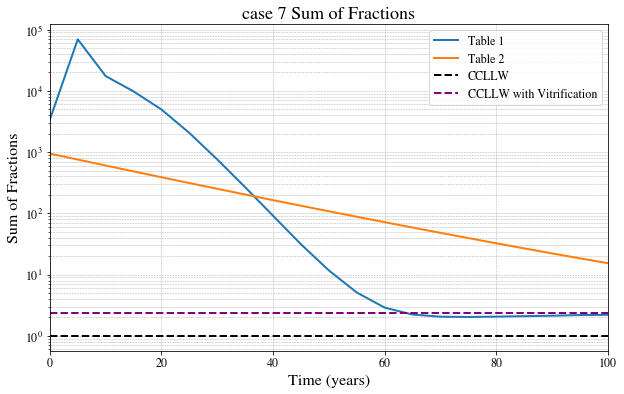

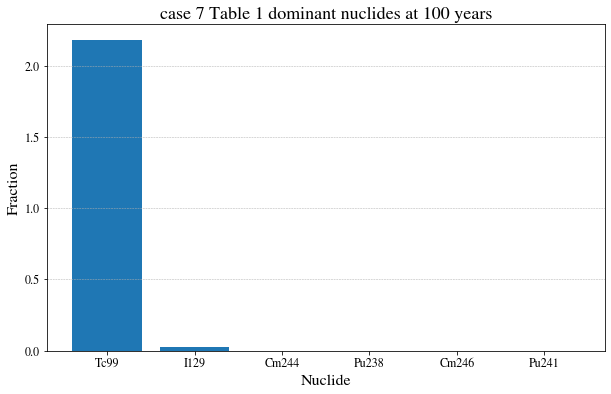

In [221]:
import openmc

from barc_blanket.materials.blanket_depletion import postprocess_coupled_depletion, plot_results
from barc_blanket.utilities import working_directory, CROSS_SECTIONS, CHAIN_FILE

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

def main():
    with working_directory("./depletion_results_final/barc-v7-10-percent-waste-sludge-fertile-removed"):
        postprocess_coupled_depletion(5, remove_C14=True)
        plot_results(case, print_name=case)
main()

case 2 [1.1388029580497545, 1.0459176893144304, 1.0275480272098036, 1.023569209770805, 1.0186560220086436, 1.0216636975629672, 1.0241000814730032, 1.0271992078421888, 1.0370033195482675, 1.044423480038452, 1.0449868339243347, 1.0493673532083092, 1.0515097843796144, 1.0541926682295406, 1.0571521070798764, 1.057719977462661, 1.0582383996122169, 1.058801099697118, 1.0563921390383646, 1.0570695375297512, 1.0553802131119965]
case 3 [1.1391162736180256, 1.045690074342679, 1.0272294486706226, 1.022403792904736, 1.0212944090467608, 1.021257117257284, 1.0261263517647232, 1.0274408944817477, 1.0369746955581138, 1.0437557294872102, 1.0459224096939974, 1.0492134506953308, 1.0516246091343089, 1.054482128427754, 1.055482201086867, 1.058464010833667, 1.0576237451408677, 1.0576240646281547, 1.0576735548430378, 1.0568755100213696, 1.0565446916609367]
case 4 [1.0846556784531924, 1.0375420934230544, 1.0058791466450916, 0.9896910695686065, 0.9828640213139087, 0.984422925627565, 0.9862424801500764, 0.99372

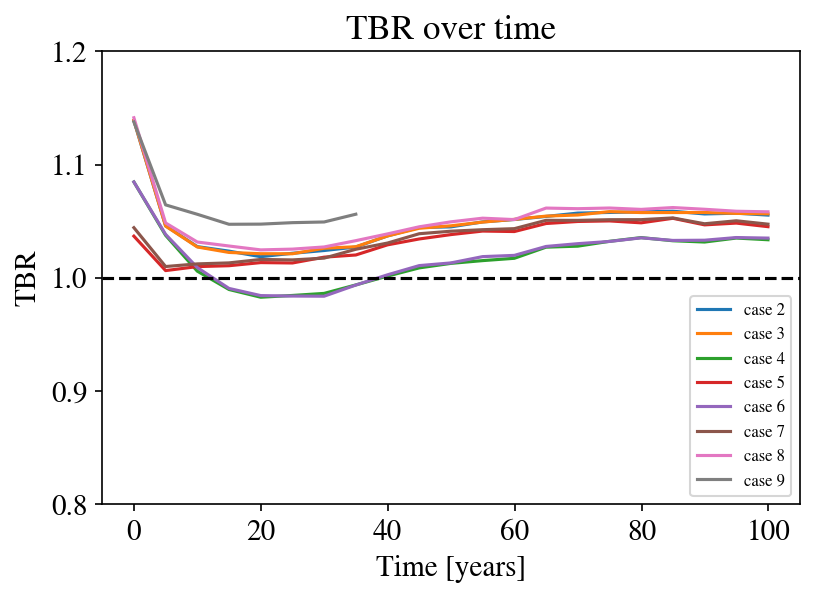

In [229]:
# Plot TBR over time for all cases

def tbr_over_time(directory):
    tbrs = []
    for filename in os.listdir(directory):
        if filename.startswith('openmc_simulation_n') and filename.endswith('.h5'):
            sp = openmc.StatePoint(directory+'/'+filename)
            tally_results = sp.get_tally(name='TBR')
            tbrs.append(np.sum(tally_results.mean.flatten()))
    return tbrs

fig, ax = plt.subplots(dpi=150)
for icase in cases.keys():
    tbrs = tbr_over_time(cases[icase])
    print(icase, tbrs)
    times = results[icase].get_times(time_units="a")
    ax.plot(times, tbrs, label=icase)
ax.set_xlabel("Time [years]")
ax.set_ylabel("TBR")

plt.title("TBR over time")
ax.set_ylim(0.8,1.2)
ax.legend(fontsize=8,loc="lower right")
ax.axhline(y=1.0, color='k', linestyle='--')

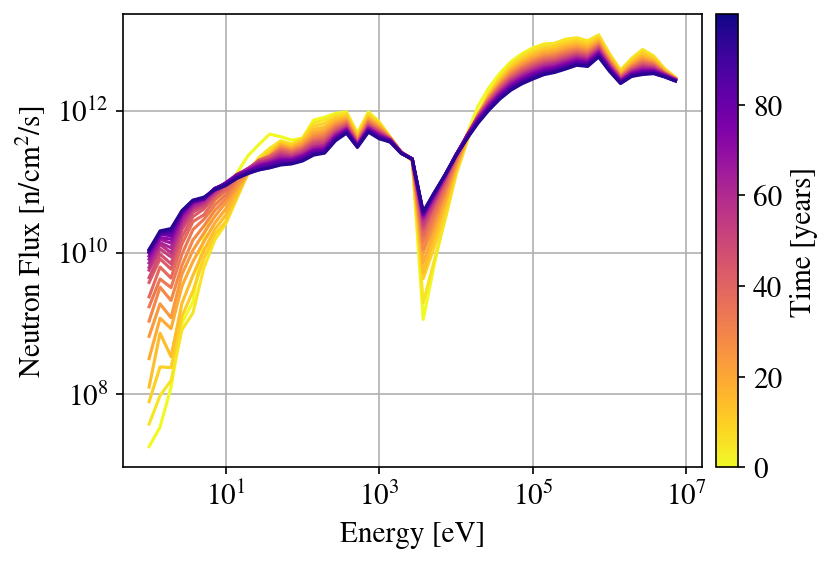

In [116]:
# Plot Neutron flux in the planket over time
import matplotlib.colors as mcolors
import matplotlib.cm as cm

efus = 17.6e6  # eV
ev2j = 1.60218e-19
Pfus = 2200e6  # W
neutron_rate = Pfus / (efus * ev2j)  # n/s

def tbr_over_time(directory):
    fluxes = []
    for filename in os.listdir(directory):
        if filename.startswith('openmc_simulation_n') and filename.endswith('.h5'):
            sp = openmc.StatePoint(directory+'/'+filename)
            tally_results = sp.get_tally(name='flux_blanket')
            energies = tally_results.filters[1].bins[:,0]
            fluxes.append(tally_results.mean[:,0,0])
        else:
            continue
        #fluxes = np.array(fluxes)
    return energies, np.array(fluxes)

fig, ax = plt.subplots(dpi=150)
times = results[case].get_times(time_units="a")
energies, fluxes = tbr_over_time(cases[case])
fluxes *= neutron_rate / 14 / 40228513
for i in np.arange(times.size):
    p = ax.loglog(energies, fluxes[i,::2], label=times[i],color=plt.cm.plasma_r(i/times.size))

# Create a ScalarMappable object to map scalar data to colors
norm = mcolors.Normalize(vmin=min(times), vmax=max(times))
sm = cm.ScalarMappable(cmap=plt.cm.plasma_r, norm=norm)
sm.set_array([])
# Add colorbar to the right of the plot
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Time [years]')

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Neutron Flux [n/cm$^2$/s]")
ax.grid()
plt.show()

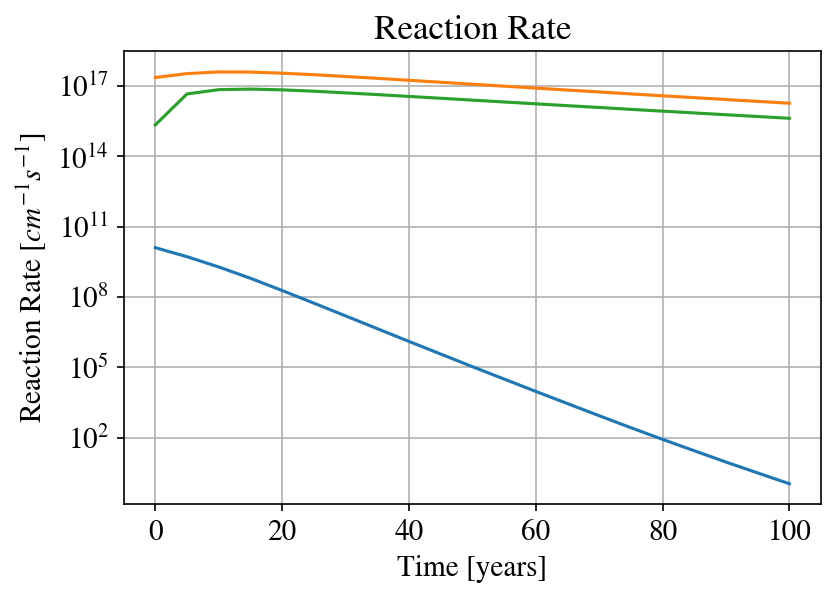

In [162]:
# Plot keff over time for all cases

fig, ax = plt.subplots(dpi=150)
#ax2 = ax.twinx()

case = "case 6"
mat_id = "8"
total_mass = np.zeros(len(results[case].get_times()))

times, reaction_rate = results[case].get_reaction_rate(mat=mat_id,nuc="U238",rx="fission")
times, reaction_rate2 = results[case].get_reaction_rate(mat=mat_id,nuc="Cs137",rx="(n,2n)")
times, reaction_rate3 = results[case].get_reaction_rate(mat=mat_id,nuc="Sr90",rx="(n,2n)")
#times, atoms = results[case].get_atoms(mat=mat_id,nuc="Pu239")
reaction_rate /=  14*40228513 # divide by total tank volume
#reaction_rate *= neutron_rate # multiply by source rate
ax.semilogy(times/60/60/24/365, reaction_rate)
ax.semilogy(times/60/60/24/365, reaction_rate2)
ax.semilogy(times/60/60/24/365, reaction_rate3)
#ax2.semilogy(times/60/60/24/365, atoms,color='red')
ax.set_ylabel(r"Reaction Rate [$cm^{-1}s^{-1}$]")
ax2.set_ylabel("Atoms")
ax.set_xlabel("Time [years]")
plt.title("Reaction Rate")
ax.grid()